# Handwriting Recognition: <br> World Vision Project

### Camilo Salazar <br> October 7th 2024

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dense, Dropout, Input, BatchNormalization

# Data Cleaning

In [4]:
# load Data
train = pd.read_csv('data/written_name_train_v2.csv')
validation = pd.read_csv('data/written_name_validation_v2.csv')

In [5]:
train.head(10)

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE
5,TRAIN_00006.jpg,LUCIE
6,TRAIN_00007.jpg,NASSIM
7,TRAIN_00008.jpg,ASSRAOUI
8,TRAIN_00009.jpg,LAVIAN
9,TRAIN_00010.jpg,MAEVA


In [6]:
validation.head(10)

,FILENAME,IDENTITY
0,VALIDATION_0001.jpg,BILEL
1,VALIDATION_0002.jpg,LAUMIONIER
2,VALIDATION_0003.jpg,LEA
3,VALIDATION_0004.jpg,JEAN-ROCH
4,VALIDATION_0005.jpg,RUPP
5,VALIDATION_0006.jpg,UNREADABLE
6,VALIDATION_0007.jpg,PICHON
7,VALIDATION_0008.jpg,DANIEL
8,VALIDATION_0009.jpg,JEREMY
9,VALIDATION_0010.jpg,JEAN-MICHEL


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330961 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  330961 non-null  object
 1   IDENTITY  330396 non-null  object
dtypes: object(2)
memory usage: 5.1+ MB


In [8]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41370 entries, 0 to 41369
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FILENAME  41370 non-null  object
 1   IDENTITY  41292 non-null  object
dtypes: object(2)
memory usage: 646.5+ KB


In [9]:
print("Number of Missing Values in train set      is ", train['IDENTITY'].isna().sum())
print("Number of Missing Values in validation set is ", validation['IDENTITY'].isna().sum())

Number of Missing Values in train set      is  565
Number of Missing Values in validation set is  78


In [10]:
train.dropna(axis=0, inplace=True)
validation.dropna(axis=0, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 330396 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  330396 non-null  object
 1   IDENTITY  330396 non-null  object
dtypes: object(2)
memory usage: 7.6+ MB


In [11]:
train['IDENTITY'].value_counts().head(10)

IDENTITY
THOMAS     1825
EMPTY      1796
LEA        1582
EMMA       1482
LUCAS      1479
HUGO       1367
CAMILLE    1367
CLEMENT    1313
MANON      1277
LOUIS      1257
Name: count, dtype: int64

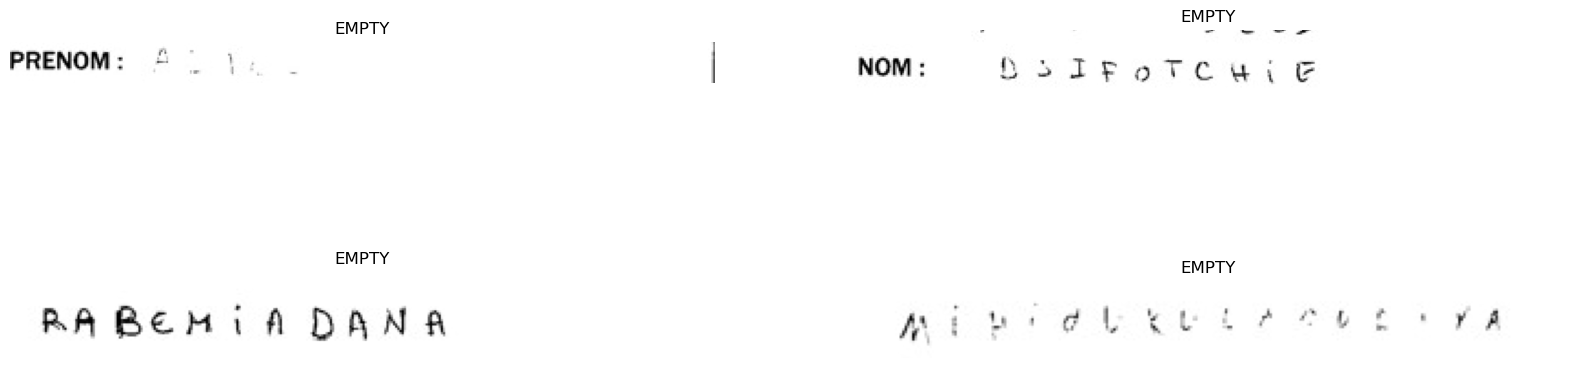

In [12]:
empty_train = train[train['IDENTITY'] == 'EMPTY']

plt.figure(figsize=(20, 20))
for i in range(0,4):
    ax = plt.subplot(2, 2, i+1)
    image = cv2.imread('data/train/' +empty_train.iloc[i,0] , cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(empty_train.iloc[i,1])
    plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [13]:
train = train[train['IDENTITY'] != 'EMPTY']
validation = validation[validation['IDENTITY'] != 'EMPTY']

train['IDENTITY'].value_counts().head(10)

IDENTITY
THOMAS     1825
LEA        1582
EMMA       1482
LUCAS      1479
HUGO       1367
CAMILLE    1367
CLEMENT    1313
MANON      1277
LOUIS      1257
THEO       1214
Name: count, dtype: int64

In [14]:
print('Length of Longest String in IDENTITY  : ' + str(train['IDENTITY'].str.len().max()))

Length of Longest String in IDENTITY  : 34


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 328600 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  328600 non-null  object
 1   IDENTITY  328600 non-null  object
dtypes: object(2)
memory usage: 7.5+ MB


In [16]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41105 entries, 0 to 41369
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FILENAME  41105 non-null  object
 1   IDENTITY  41105 non-null  object
dtypes: object(2)
memory usage: 963.4+ KB


# Data Preprocessing

In [18]:
def format_image(image):
    (h,w) = image.shape
    final_image = np.ones([64, 256])*255
    if w > 256:
        image = image[:, :256]
        
    if h > 64:
        image = image[:64, :]
    final_image[:h,:w] = image
    final_image = cv2.rotate(final_image, cv2.ROTATE_90_CLOCKWISE)
    return final_image

In [19]:
train.reset_index(inplace = True, drop=True) 
validation.reset_index(inplace = True, drop=True)

train_size = 50000
validation_size = 5000

In [21]:
train_x = []
for i in range(train_size):
    image = cv2.imread('data/train/' +train.iloc[1,0], cv2.IMREAD_GRAYSCALE)
    image = format_image(image)/255
    train_x.append(image)

validation_x = []
for i in range(validation_size):
    image = cv2.imread('data/validation/' +validation.iloc[1,0], cv2.IMREAD_GRAYSCALE)
    image = format_image(image)/255
    validation_x.append(image)

train_x = np.array(train_x).reshape(-1, 256, 64, 1)
validation_x = np.array(validation_x).reshape(-1, 256, 64, 1)

In [22]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_string_lenght = 34

def label_to_nums(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
    return np.array(label_num)

print(label_to_nums(train.loc[50, 'IDENTITY']))

[24  0  4 11]


In [23]:
train_y = np.ones([train_size,max_string_lenght])* -1
validation_y = np.ones([validation_size,max_string_lenght])* -1
for i in range(train_size):
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_nums(train.loc[i, 'IDENTITY'])

for i in range(validation_size):
    validation_y[i, 0:len(validation.loc[i, 'IDENTITY'])]= label_to_nums(validation.loc[i, 'IDENTITY'])

## Model Building

In [25]:
print(train_y[50])

[24.  0.  4. 11. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


In [55]:

def build_handwriting_recognition_model(input_shape=(64, 256, 1), max_str_len=34):
    CNN_model = Sequential()

    # Input layer
    CNN_model.add(Input(shape=input_shape))
    
    # Convolutional layers for feature extraction
    CNN_model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    CNN_model.add(BatchNormalization())
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))  # Downsample
    CNN_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    CNN_model.add(BatchNormalization())
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))  # Downsample
    CNN_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    CNN_model.add(BatchNormalization())
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))  # Downsample
    
    # Flatten the output from the CNN layers
    CNN_model.add(Flatten())

    # Fully connected layers (Dense layers)
    CNN_model.add(Dense(128, activation='relu'))
    CNN_model.add(Dropout(0.5))  # Add dropout to prevent overfitting

    CNN_model.add(Dense(64, activation='relu'))

    CNN_model.add(Dense(max_str_len, activation='linear'))

    return CNN_model

# Build the model
model = build_handwriting_recognition_model()

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Show model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 64, 256, 64)         │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 256, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 128, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 128, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 128, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 32, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │      16,777,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 34)                  │           4,386 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,186,210 (65.56 MB)

 Trainable params: 17,185,314 (65.56 MB)

 Non-trainable params: 896 (3.50 KB)

In [41]:
history = model.fit(
    train_x,
    train_y,
    validation_data=(validation_x, validation_y),
    batch_size=32,
    epochs=10,
    verbose=1
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 518s 327ms/step - accuracy: 0.2097 - loss: 21.6715 - val_accuracy: 0.1572 - val_loss: 177.2490
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 507s 324ms/step - accuracy: 0.2455 - loss: 13.6865 - val_accuracy: 0.1572 - val_loss: 135.2990
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 503s 322ms/step - accuracy: 0.2489 - loss: 13.6764 - val_accuracy: 0.0896 - val_loss: 148.9626
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 527s 337ms/step - accuracy: 0.2478 - loss: 13.6697 - val_accuracy: 0.1572 - val_loss: 85.1969
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 507s 324ms/step - accuracy: 0.2480 - loss: 13.6021 - val_accuracy: 0.1572 - val_loss: 77.0997
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 509s 326ms/step - accuracy: 0.2485 - loss: 13.6160 - val_accuracy: 0.2370 - val_loss: 15.6407
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 505s 323ms/step - accuracy: 0.2467 - loss: 13.6674 - val_accuracy: 0.1532 - val_loss: 17.1076
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 521

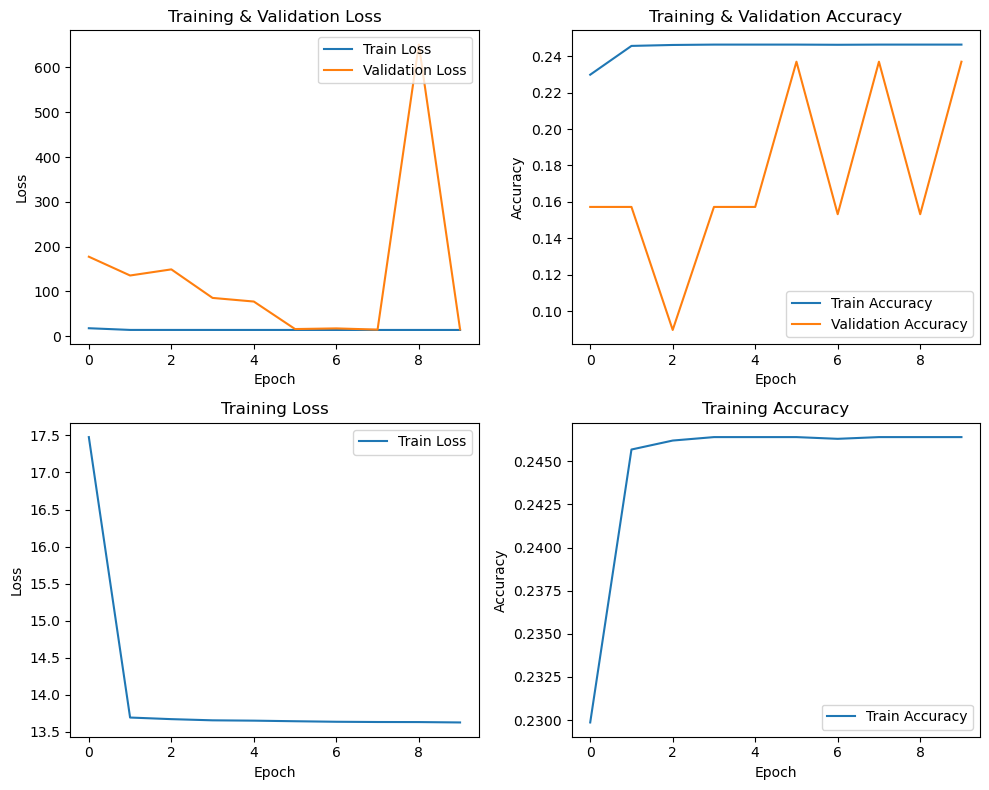

In [53]:
# Create a figure with 4 subplots: 
plt.figure(figsize=(10, 8))

# 1st subplot: Training & Validation Loss
ax1 = plt.subplot(2, 2, 1)
ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training & Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')

# 2nd subplot: Training & Validation Accuracy
ax2 = plt.subplot(2, 2, 2)
ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training & Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')

# 3rd subplot: Only Training Loss
ax3 = plt.subplot(2, 2, 3)
ax3.plot(history.history['loss'], label='Train Loss')
ax3.set_title('Training Loss')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.legend(loc='upper right')

# 4th subplot: Only Training Accuracy
ax4 = plt.subplot(2, 2, 4)
ax4.plot(history.history['accuracy'], label='Train Accuracy')
ax4.set_title('Training Accuracy')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy')
ax4.legend(loc='lower right')

# Adjust layout to fit all subplots nicely
plt.tight_layout()

# Show the plots
plt.show()